In [2]:
#import autograd.numpy as np  # Thinly-wrapped numpy
#from autograd import grad
#from autograd import hessian
import numpy as np
from scipy.optimize import minimize,Bounds,LinearConstraint,NonlinearConstraint
import matplotlib.pyplot as pl
import copy
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
random_x=np.random.uniform(21,37,50).reshape((-1,1))
random_y=np.random.uniform(21,37,50).reshape((-1,1))
obs_np=np.concatenate([random_x,random_y],axis=1)

In [4]:
def J_vehicle(x_c):
    ret_array=np.array([[np.cos(x_c[-1]),0.],[np.sin(x_c[-1]),0.],[0.,1.]])
    return(ret_array)

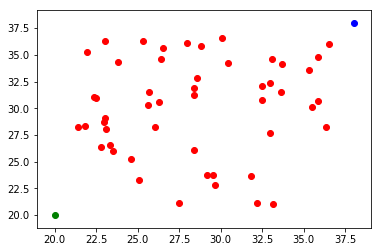

In [5]:
start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')

In [6]:
def rollout_sc(control,start,ts=0.1,th=50):
    cur_state=copy.copy(start)
    points_list=[]
    for i in range(th):
        J=J_vehicle(cur_state)
        x_dot=np.matmul(J,control)
        cur_state+=x_dot*ts
        points_list.append(copy.copy(cur_state))
    return(np.array(points_list))   


In [7]:
control=np.array([1.,-0.1])
points_np=rollout_sc(control,start_point)

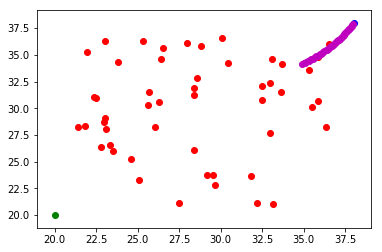

In [8]:
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.scatter(points_np[:,0],points_np[:,1],c='m')

In [9]:
steps=np.arange(-3.1,3.1,0.05)

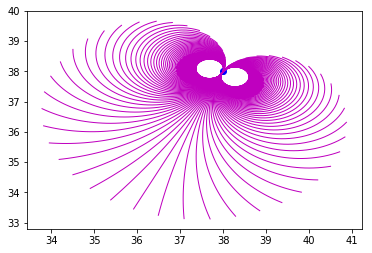

In [10]:
#holding controls
for i in range(len(steps)):
    control=np.array([1.,steps[i]])
    points_np=rollout_sc(control,start_point)
    pl.plot(points_np[:,0],points_np[:,1],c='m',lw=1)
pl.scatter(start_point[0],start_point[1],c='b')
#pl.scatter(end_point[0],end_point[1],c='g')
#pl.scatter(random_x,random_y,c='r')

In [11]:
control=np.array([0.,0.])
points_np=rollout_sc(control,start_point)

In [12]:
def ttc_rollout(control,start,ts=0.1,th=50):
    cur_state=copy.copy(start)
    count=0.0
    dist_sum=0.0
    for i in range(th):
        J=J_vehicle(cur_state)
        x_dot=np.matmul(J,control)
        cur_state+=x_dot*ts
        count+=1.0
        d_cost=np.linalg.norm(cur_state[:2]-end_point)
        #dist_sum+=d_cost
        dist=np.linalg.norm(cur_state[:2]-obs_np,axis=1)
        if((np.min(dist)<0.5)):
            #cost=(dist_sum/count)+(50./((count*ts)))
            cost=d_cost+(50./((count*ts)**2))
            return(cost)
    #cost=(dist_sum/count)#+(5./((count*ts)))
    cost=d_cost
    return(cost)

def rollout(x_dot,cur_point,ts=0.1,th=50):
    x_c=copy.copy(cur_point)
    x_dot_r=x_dot.reshape(-1)
    cost_v=0.0
    for i in range(0,th):
        jac_v=J_vehicle(x_c)
        nextstep=np.matmul(jac_v,x_dot_r)*ts
        x_c=x_c+nextstep
        norm_dist=np.linalg.norm(x_c[:2]-end_point)
        obs_ratio=15./(ts*(i+1)*(np.min(np.linalg.norm(x_c[:2]-obs_np,axis=1))))
        #obs_ratio=np.max((1./(2.5*sigma))*(np.exp(-0.5*(np.linalg.norm(x_c[:2]-obs_np,axis=1)/sigma)**2)))
        #obs_ratio=np.max(np.exp(-(np.linalg.norm(x_c[:2]-obs_np,axis=1))**2))
        if(norm_dist<0.1):
            return(cost_v)
        cost_v=cost_v+(norm_dist)+(obs_ratio)
    return(cost_v)


In [13]:
%%time
ttc_rollout(control,start_point)

CPU times: user 11.9 ms, sys: 4.54 ms, total: 16.5 ms
Wall time: 12.7 ms


25.45584412271571

In [14]:
%%time
rollout(control,start_point)

CPU times: user 16.9 ms, sys: 2.24 ms, total: 19.2 ms
Wall time: 15.4 ms


1547.5748711325691

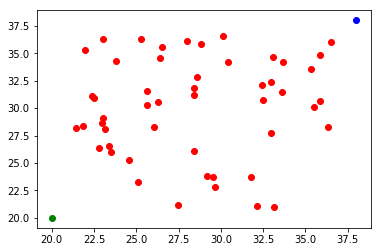

In [15]:
pl.scatter(points_np[:,0],points_np[:,1],c='m',s=4)
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.scatter(random_x,random_y,c='r')

In [16]:
single_con=np.array([1.5, 0.])
ubounds=np.array([1.5,1.])
lbounds=np.array([0.,-1.])
ubounds=ubounds.reshape(-1)
lbounds=lbounds.reshape(-1)
LinBounds=Bounds(lbounds,ubounds)
#A_b=np.eye(2)
#LinBounds=LinearConstraint(A_b,lbounds,ubounds)

In [17]:
#start_point=np.array([27.,36.5,-2.5])
start_point=np.array([35.,35.,-1.5])
end_point=np.array([20.,20.])

In [18]:
%%time
res=minimize(ttc_rollout,single_con,method='slsqp',args=(start_point),bounds=LinBounds,options={'ftol':0.5})

CPU times: user 10.1 ms, sys: 1.45 ms, total: 11.5 ms
Wall time: 8.59 ms


In [19]:
%%time
res=minimize(rollout,single_con,method='slsqp',args=(start_point),bounds=LinBounds,options={'ftol':0.5})

CPU times: user 44.2 ms, sys: 7.16 ms, total: 51.3 ms
Wall time: 41.9 ms


In [20]:
res.x

array([ 1.5       , -0.28785161])

In [21]:
pos=rollout_sc(res.x,start_point)

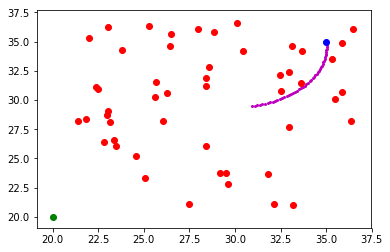

In [22]:
pl.scatter(pos[:,0],pos[:,1],c='m',s=4)
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.scatter(random_x,random_y,c='r')
#pl.xlim([24,34])
#pl.ylim([24,34])

In [23]:
def integrate_next_step(x_0,x_dot,ts_c=0.1):
    x_c=copy.copy(x_0)
    jac_v=J_vehicle(x_c)
    x_c+=np.matmul(jac_v,x_dot)*ts_c    
    return(x_c)

In [24]:
%%time
start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
cur_point=copy.copy(start_point)
pos_list=[]
vel_list=[]
single_con=np.array([1.5, 0.])
for i in range(0,200):
    pos_list.append(copy.copy(cur_point))
    res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
#     cur_con=copy.copy(res.x)
    cur_con=res.x
    next_point=integrate_next_step(cur_point,cur_con)
    cur_point=next_point
    vel_list.append(cur_con)
    if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
        break

NameError: name 'cur_con' is not defined

In [25]:
pos_np=np.array(pos_list)
vel_np=np.array(vel_list)

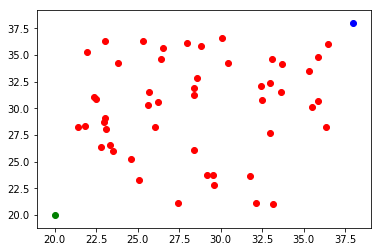

In [26]:
pl.scatter(pos_np[:,0],pos_np[:,1],s=2)
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')

In [27]:
%%time
ttc_rollout(cont,start_point)

NameError: name 'cont' is not defined

In [28]:
def ttc_checkCol(control,start,ts=0.1,th=40):
    cur_state=copy.copy(start)
    count=0.0
    dist_sum=0.0
    for i in range(th):
        J=J_vehicle(cur_state)
        x_dot=np.matmul(J,control)
        cur_state+=x_dot*ts
        dist=np.linalg.norm(cur_state[:2]-obs_np,axis=1)
        if((np.min(dist)<1.)):
            return(i*ts)
    return(th*ts) 

In [29]:
ttc_checkCol(res.x,start_point)

0.9

# Fast rollout in Fortran

In [30]:
import fast_rollout

## Docs for args

In [31]:
print(fast_rollout.rollout.__doc__)

cost = rollout(con,init_x,targ_x,obs,[obs_n,obs_r_frac,x_len,con_len,n,ts])

Wrapper for ``rollout``.

Parameters
----------
con : input rank-1 array('d') with bounds (con_len)
init_x : input rank-1 array('d') with bounds (x_len)
targ_x : input rank-1 array('d') with bounds (x_len - 1)
obs : input rank-2 array('f') with bounds (obs_n,x_len - 1)

Other Parameters
----------------
obs_n : input int, optional
    Default: shape(obs,0)
obs_r_frac : input float, optional
    Default: 15.0
x_len : input int, optional
    Default: len(init_x)
con_len : input int, optional
    Default: len(con)
n : input int, optional
    Default: 50
ts : input float, optional
    Default: 0.1

Returns
-------
cost : float



In [32]:
%%timeit
rollout(control,start_point)

2.35 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit
fast_rollout.rollout(
    control,
    init_x=start_point,
    targ_x=end_point,
    obs=obs_np,
)

32.9 µs ± 5.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Supply args to for fast_rollout in scipy

In [34]:
%%time
start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
# cur_point=copy.copy(start_point)
cur_point=start_point.copy()

start_point=np.random.uniform(21,37,3)
start_point[-1] = -2.
end_point=np.random.uniform(21,37,2)

print(start_point, end_point)

cur_point=copy.copy(start_point)
pos_list=[]
vel_list=[]
for i in range(0,500):
    pos_list.append(copy.copy(cur_point))
    res=minimize(fast_rollout.rollout,
                 cur_con,
                 method='slsqp',
                 args=(cur_point, end_point, obs_np),
                 bounds=LinBounds,
                 options={'ftol':0.1}
                )
#     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
    cur_con=copy.copy(res.x)
    cur_con=res.x
    next_point=integrate_next_step(cur_point,cur_con)
    cur_point=next_point
    vel_list.append(cur_con)
    if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
        break
print(i)

[33.03702476 27.481199   -2.        ] [29.2072092  22.06780888]


NameError: name 'cur_con' is not defined

In [35]:
%load_ext cython
%load_ext line_profiler

In [36]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy.optimize import minimize
import fast_rollout
import cython


from scipy.optimize.slsqp import _minimize_slsqp








import time











@cython.boundscheck(False)
@cython.wraparound(False)
cpdef a(double [:] start_point, double [:] end_point, double [:] start_con, int n,
       object LinBounds, double [:, :] obs_np, float ts=.1, float tol=.1):
    cdef double t = 0
    cdef double tt = 0
    cdef double tmp = 0
    cdef double [:] cur_point = np.empty(start_point.shape[0])
    cdef double [:] cur_con = np.empty(start_con.shape[0])
    
    cdef double [:, :] J = np.zeros((3, 2), dtype=np.double)
    
    cdef double [:, :] poses = np.zeros((n, start_point.shape[0]))
    cdef double [:, :] veles = np.zeros((n, start_con.shape[0]))
    cur_point[:] = start_point
    cur_con[:] = start_con
    
    cdef object res
    
    cdef Py_ssize_t x, y, k
    cdef Py_ssize_t x_max = J.shape[0]
    cdef Py_ssize_t y_max = cur_con.shape[0]
    cdef Py_ssize_t inner = J.shape[1]
    
    for i in range(n):
#         res=minimize(fast_rollout.rollout,
#                     cur_con,
#                     method='slsqp',
#                     args=(cur_point, end_point, obs_np),
#                     bounds=LinBounds,
#                     options={'ftol':0.1}
#                     )
    
        tmp = time.time()
        res = _minimize_slsqp(
            fast_rollout.rollout,
            x0=cur_con,
            args=(cur_point, end_point, obs_np),
            jac=None,
            bounds=[(0.0, 1.5), (-1.0, 1.0)],
            constraints=[],
            callback=None,
            ftol=0.1,
        )
        tt += tmp


        cur_con = res.x
        
        with nogil:
#         if 1:
         
            # fast set jacobian matrix
            J[0, 0] = cos(cur_point[2])
            J[1, 0] = sin(cur_point[2])
            J[2, 1] = 1.           
            
            poses[i, :] = cur_point
            
            for x in range(x_max):#3
                for y in range(y_max):#2
                    # coordinate boundary conditions
                    for k in range(inner):#2
                        cur_point[x] += J[x, k] * cur_con[k] * ts
            

#             cur_point = np.asarray(cur_point) + np.matmul(np.asarray(J), np.asarray(cur_con)) * ts   
                        
            veles[i, :] = cur_con

            if sqrt((cur_point[0] - end_point[0])**2 + (cur_point[1] - end_point[1])**2) < tol:
                break
        
    return np.asarray(poses)[:i], np.asarray(veles)[:i]
    
    
    
    
    
    
    
    
    
    
    
    
# %%cython
# import numpy as np
# cimport numpy as np
# from libc.math cimport sin, cos, sqrt
# from scipy.optimize import minimize
# import fast_rollout
# import cython


# from scipy.optimize.slsqp import _minimize_slsqp








# import time



# def J_vehicle(x_c):
#     ret_array=np.array([[np.cos(x_c[-1]),0.],[np.sin(x_c[-1]),0.],[0.,1.]])
#     return(ret_array)

# def integrate_next_step(x_0,x_dot,ts_c=0.1):
#     x_c=x_0.copy()
#     jac_v=J_vehicle(x_c)
#     x_c+=np.matmul(jac_v,x_dot)*ts_c    
#     return(x_c)



# import copy



# @cython.boundscheck(False)
# @cython.wraparound(False)
# cpdef a(double [:] start_point, double [:] end_point, double [:] start_con, int n,
#        object LinBounds, double [:, :] obs_np, float ts=.1, float tol=.1):
#     cdef double t = 0
#     cdef double tt = 0
#     cdef double tmp = 0
#     cdef double [:] cur_point = np.empty(start_point.shape[0])
#     cdef double [:] cur_con = np.empty(start_con.shape[0])
    
#     cdef double [:, :] J = np.zeros((3, 2), dtype=np.double)
    
#     cdef double [:, :] poses = np.zeros((n, start_point.shape[0]))
#     cdef double [:, :] veles = np.zeros((n, start_con.shape[0]))
#     cur_point[:] = start_point
#     cur_con[:] = start_con
    
#     cdef object res
    
#     cdef Py_ssize_t x, y, k
#     cdef Py_ssize_t x_max = J.shape[0]
#     cdef Py_ssize_t y_max = cur_con.shape[0]
#     cdef Py_ssize_t inner = J.shape[1]
    
    
    
#     cur_point=copy.copy(start_point)
#     pos_list=[]
#     vel_list=[]
#     for i in range(0,500):
#         pos_list.append(copy.copy(cur_point))
#         res=minimize(fast_rollout.rollout,
#                      cur_con,
#                      method='slsqp',
#                      args=(cur_point, end_point, obs_np),
#                      bounds=LinBounds,
#                      options={'ftol':0.1}
#                     )
#     #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
#         cur_con=copy.copy(res.x)
#         cur_con=res.x
#         next_point=integrate_next_step(cur_point,cur_con)
#         cur_point=next_point
#         vel_list.append(cur_con)
#         if(np.linalg.norm(np.asarray(cur_point)[:2]-end_point)<0.1):
#             break
#     return pos_list, vel_list
    
    
    
#     for i in range(n):
# #         res=minimize(fast_rollout.rollout,
# #                     cur_con,
# #                     method='slsqp',
# #                     args=(cur_point, end_point, obs_np),
# #                     bounds=LinBounds,
# #                     options={'ftol':0.1}
# #                     )
    
#         tmp = time.time()
#         res = _minimize_slsqp(
#             fast_rollout.rollout,
#             x0=cur_con,
#             args=(cur_point, end_point, obs_np),
#             jac=None,
#             bounds=[(0.0, 1.5), (-1.0, 1.0)],
#             constraints=[],
#             callback=None,
#             ftol=0.1,
#         )
#         tt += time.time() - tmp
#         tmp = time.time()


#         cur_con = res.x
        
# #         with nogil:
#         if 1:
         
#             # fast set jacobian matrix
#             J[0, 0] = cos(cur_point[2])
#             J[1, 0] = sin(cur_point[2])
#             J[2, 1] = 1.           
            
#             poses[i, :] = cur_point
            
# #             for x in range(x_max):#3
# #                 for y in range(y_max):#2
# #                     # coordinate boundary conditions
# #                     for k in range(inner):#2
# #                         cur_point[x] += J[x, k] * cur_con[k] * ts
            

# #             cur_point = np.asarray(cur_point) + np.matmul(np.asarray(J), np.asarray(cur_con)) * ts   
                        
#             veles[i, :] = cur_con
        
#             cur_point = integrate_next_step(cur_point,cur_con)

            
#             if sqrt((cur_point[0] - end_point[0])**2 + (cur_point[1] - end_point[1])**2) < tol:
#                 break
                
#         t += time.time() - tmp
#     print(tt, t)
#     print('>>', tt / (tt + t), t / (tt + t))
        
#     return np.asarray(poses)[:i], np.asarray(veles)[:i]
    
    

In [37]:
%%cython

import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
# from scipy.optimize import minimize
import fast_rollout
import cython

from scipy.optimize.slsqp import _minimize_slsqp


cpdef new_bounds_to_old(lb, ub, int n):
    """Convert the new bounds representation to the old one.

    The new representation is a tuple (lb, ub) and the old one is a list
    containing n tuples, i-th containing lower and upper bound on a i-th
    variable.
    """
    lb = np.asarray(lb)
    ub = np.asarray(ub)
    if lb.ndim == 0:
        lb = np.resize(lb, n)
    if ub.ndim == 0:
        ub = np.resize(ub, n)

    lb = [x if x > -np.inf else None for x in lb]
    ub = [x if x < np.inf else None for x in ub]

    return list(zip(lb, ub))


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef a(double [:] start_point, double [:] end_point, double [:] start_con, int n,
       object LinBounds, double [:, :] obs_np, float ts=.1, float tol=.1):
    
#     pos_list=[]
#     vel_list=[]

#     cur_point=np.asarray(start_point).copy()
#     cur_con=np.asarray(start_con).copy()
    
#     for i in range(0,n):
#         pos_list.append(copy.copy(cur_point))
#         res=minimize(fast_rollout.rollout,
#                      cur_con,
#                      method='slsqp',
#                      args=(cur_point, end_point, obs_np),
#                      bounds=LinBounds,
#                      options={'ftol':0.1}
#                     )
#     #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
#         cur_con=copy.copy(res.x)
#         cur_con=res.x
#         cur_point=integrate_next_step(cur_point,cur_con)
#         vel_list.append(cur_con)
#         if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
#             break
#     return np.array(pos_list), np.array(vel_list)
    
    ##################################################################################
    
    cdef double tmp = 0.
    cdef double [:] cur_point = np.empty(start_point.shape[0])
    cdef double [:] cur_con = np.empty(start_con.shape[0])
    
    cdef double [:, :] J = np.zeros((3, 2), dtype=np.double)
    
    cdef double [:, :] poses = np.zeros((n, start_point.shape[0]))
    cdef double [:, :] veles = np.zeros((n, start_con.shape[0]))
    
    cur_point[:] = start_point
    cur_con[:] = start_con
    
    cdef object res
    
    cdef Py_ssize_t x, y
    cdef Py_ssize_t x_max = J.shape[0]
    cdef Py_ssize_t y_max = J.shape[1]
    
    cdef object bounds = new_bounds_to_old(
        LinBounds.lb, 
        LinBounds.ub, 
        cur_con.shape[0]
    )
    
    
    for i in range(n):
        
        
#         res = minimize(fast_rollout.rollout,
#                     cur_con,
#                     method='slsqp',
#                     args=(cur_point, end_point, obs_np),
#                     bounds=LinBounds,
#                     options={'ftol':0.1}
#                     )
    
        res = _minimize_slsqp(
            fast_rollout.rollout,
            x0=cur_con,
            args=(cur_point, end_point, obs_np),
            jac=None,
            bounds=bounds,
            constraints=[],
            callback=None,
            ftol=0.1,
        )

        cur_con = res.x
    
        with nogil:

            poses[i, :] = cur_point
            veles[i, :] = cur_con

            # fast set jacobian matrix
            J[0, 0] = ts * cos(cur_point[2])
            J[1, 0] = ts * sin(cur_point[2])
            J[2, 1] = ts #* 1. 

            for x in range(x_max):
                # tmp = 0.
                for y in range(y_max):#2
                    # tmp += J[x, y] * cur_con[y]
                    cur_point[x] += J[x, y] * cur_con[y]
                # cur_point[x] += tmp * ts


            if sqrt((cur_point[0] - end_point[0])**2 + (cur_point[1] - end_point[1])**2) < tol:
                break

    return np.asarray(poses)[:i], np.asarray(veles)[:i]

# new

In [38]:
from scipy.optimize.optimize import wrap_function, OptimizeResult, _check_unknown_options

In [39]:
%%cython

import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
# from scipy.optimize import minimize
import fast_rollout
import cython

# from scipy.optimize.slsqp import _minimize_slsqp


cpdef new_bounds_to_old(lb, ub, int n):
    """Convert the new bounds representation to the old one.

    The new representation is a tuple (lb, ub) and the old one is a list
    containing n tuples, i-th containing lower and upper bound on a i-th
    variable.
    """
    lb = np.asarray(lb)
    ub = np.asarray(ub)
    if lb.ndim == 0:
        lb = np.resize(lb, n)
    if ub.ndim == 0:
        ub = np.resize(ub, n)

    lb = [x if x > -np.inf else None for x in lb]
    ub = [x if x < np.inf else None for x in ub]

    return list(zip(lb, ub))









import numpy as np
from scipy.optimize._slsqp import slsqp
from numpy import (zeros, array, linalg, append, asfarray, concatenate, finfo,
                   vstack, exp, inf, isfinite, atleast_1d)
from scipy.optimize.optimize import wrap_function, OptimizeResult, _check_unknown_options



_epsilon = np.sqrt(finfo(float).eps)











cdef approx_jacobian(x, func, epsilon):
    """
    Approximate the Jacobian matrix of a callable function.

    Parameters
    ----------
    x : array_like
        The state vector at which to compute the Jacobian matrix.
    func : callable f(x,*args)
        The vector-valued function.
    epsilon : float
        The perturbation used to determine the partial derivatives.
    args : sequence
        Additional arguments passed to func.

    Returns
    -------
    An array of dimensions ``(lenf, lenx)`` where ``lenf`` is the length
    of the outputs of `func`, and ``lenx`` is the number of elements in
    `x`.

    Notes
    -----
    The approximation is done using forward differences.

    """
    x0 = asfarray(x)
    f0 = atleast_1d(func(*((x0,))))
    jac = zeros([len(x0), len(f0)])
    dx = zeros(len(x0))
    for i in range(len(x0)):
        dx[i] = epsilon
        jac[i] = (func(*((x0+dx,))) - f0)/epsilon
        dx[i] = 0.0

    return jac.transpose()







cpdef _minimize_slsqp(func, x0, args=(), jac=None, bounds=None,
#                     constraints=(),
                    maxiter=100, ftol=1.0E-6,
                    eps=_epsilon, callback=None):
    """
    Minimize a scalar function of one or more variables using Sequential
    Least SQuares Programming (SLSQP).

    Options
    -------
    ftol : float
        Precision goal for the value of f in the stopping criterion.
    eps : float
        Step size used for numerical approximation of the Jacobian.
    disp : bool
        Set to True to print convergence messages. If False,
        `verbosity` is ignored and set to 0.
    maxiter : int
        Maximum number of iterations.

    """
    fprime = jac
    iter = maxiter
    acc = ftol
    epsilon = eps

    # Transform x0 into an array.
    x = asfarray(x0).flatten()

    # Set the parameters that SLSQP will need
    # meq, mieq: number of equality and inequality constraints
    meq = 0
    mieq = 0
    # m = The total number of constraints
    m = meq + mieq
    # la = The number of constraints, or 1 if there are no constraints
    la = array([1, m]).max()
    # n = The number of independent variables
    n = len(x)

    # Define the workspaces for SLSQP
    n1 = n + 1
    mineq = m - meq + n1 + n1
    len_w = (3*n1+m)*(n1+1)+(n1-meq+1)*(mineq+2) + 2*mineq+(n1+mineq)*(n1-meq) \
            + 2*meq + n1 + ((n+1)*n)//2 + 2*m + 3*n + 3*n1 + 1
    len_jw = mineq
    w = zeros(len_w)
    jw = zeros(len_jw)

    # Decompose bounds into xl and xu
    if bounds is None or len(bounds) == 0:
        xl = np.empty(n, dtype=float)
        xu = np.empty(n, dtype=float)
        xl.fill(np.nan)
        xu.fill(np.nan)
    else:
        bnds = array(bounds, float)
        if bnds.shape[0] != n:
            raise IndexError('SLSQP Error: the length of bounds is not '
                             'compatible with that of x0.')

        with np.errstate(invalid='ignore'):
            bnderr = bnds[:, 0] > bnds[:, 1]

        if bnderr.any():
            raise ValueError('SLSQP Error: lb > ub in bounds')
        xl, xu = bnds[:, 0], bnds[:, 1]

        # Mark infinite bounds with nans; the Fortran code understands this
        infbnd = ~isfinite(bnds)
        xl[infbnd[:, 0]] = np.nan
        xu[infbnd[:, 1]] = np.nan

    # Clip initial guess to bounds (SLSQP may fail with bounds-infeasible
    # initial point)
    have_bound = np.isfinite(xl)
    x[have_bound] = np.clip(x[have_bound], xl[have_bound], np.inf)
    have_bound = np.isfinite(xu)
    x[have_bound] = np.clip(x[have_bound], -np.inf, xu[have_bound])
    
    #####################################
    
    # Wrap func
    feval, func = wrap_function(func, args)

    # Wrap fprime, if provided, or approx_jacobian if not
    if fprime:
        geval, fprime = wrap_function(fprime, args)
    else:
        geval, fprime = wrap_function(approx_jacobian, (func, epsilon))
        
        

    # Initialize the iteration counter and the mode value
    mode = array(0, int)
    acc = array(acc, float)
    majiter = array(iter, int)
    majiter_prev = 0

    # Initialize internal SLSQP state variables
    alpha = array(0, float)
    f0 = array(0, float)
    gs = array(0, float)
    h1 = array(0, float)
    h2 = array(0, float)
    h3 = array(0, float)
    h4 = array(0, float)
    t = array(0, float)
    t0 = array(0, float)
    tol = array(0, float)
    iexact = array(0, int)
    incons = array(0, int)
    ireset = array(0, int)
    itermx = array(0, int)
    line = array(0, int)
    n1 = array(0, int)
    n2 = array(0, int)
    n3 = array(0, int)
    
    # Compute the constraints
    c_eq = zeros(0)
    c_ieq = zeros(0)
    # Now combine c_eq and c_ieq into a single matrix
    c = concatenate((c_eq, c_ieq))
    
    # Compute the normals of the constraints
    a_eq = zeros((meq, n))
    a_ieq = zeros((mieq, n))
    # Now combine a_eq and a_ieq into a single a matrix
    if m == 0:  # no constraints
        a = zeros((la, n))
    else:
        a = vstack((a_eq, a_ieq))
    a = concatenate((a, zeros([la, 1])), 1)

    while 1:

        if mode == 0 or mode == 1:  # objective and constraint evaluation required

            # Compute objective function
            fx = func(x)
#             try:
#                 fx = float(np.asarray(fx))
#             except (TypeError, ValueError):
#                 raise ValueError("Objective function must return a scalar")

        if mode == 0 or mode == -1:  # gradient evaluation required

            # Compute the derivatives of the objective function
            # For some reason SLSQP wants g dimensioned to n+1
            g = append(fprime(x), 0.0)

        # Call SLSQP
        slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,
              alpha, f0, gs, h1, h2, h3, h4, t, t0, tol,
              iexact, incons, ireset, itermx, line, 
              n1, n2, n3)
        
        # If exit mode is not -1 or 1, slsqp has completed
        if abs(mode) != 1:
            break

#         majiter_prev = int(majiter)
    
    return x

#     return OptimizeResult(x=x, fun=fx, jac=g[:-1], nit=int(majiter),
#                           nfev=feval[0], njev=geval[0], status=int(mode),
#                           message=exit_modes[int(mode)], success=(mode == 0))









@cython.boundscheck(False)
@cython.wraparound(False)
cpdef prop_traj(double [:] start_point, double [:] end_point, double [:] start_con, int n,
       object LinBounds, double [:, :] obs_np, float ts=.1, float targ_tol=.1):
    
#     pos_list=[]
#     vel_list=[]

#     cur_point=np.asarray(start_point).copy()
#     cur_con=np.asarray(start_con).copy()
    
#     for i in range(0,n):
#         pos_list.append(copy.copy(cur_point))
#         res=minimize(fast_rollout.rollout,
#                      cur_con,
#                      method='slsqp',
#                      args=(cur_point, end_point, obs_np),
#                      bounds=LinBounds,
#                      options={'ftol':0.1}
#                     )
#     #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
#         cur_con=copy.copy(res.x)
#         cur_con=res.x
#         cur_point=integrate_next_step(cur_point,cur_con)
#         vel_list.append(cur_con)
#         if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
#             break
#     return np.array(pos_list), np.array(vel_list)
    
    ##################################################################################
    
    # cdef double tmp = 0.
    cdef double [:] cur_point = np.empty(start_point.shape[0], dtype=np.double)
    cdef double [:] cur_con = np.empty(start_con.shape[0], dtype=np.double)
    cdef double [:] x = np.empty(start_con.shape[0], dtype=np.double)
    
    cdef double [:, :] J = np.zeros((3, 2), dtype=np.double)
    
    cdef double [:, :] poses = np.zeros((n, start_point.shape[0]), dtype=np.double)
    cdef double [:, :] veles = np.zeros((n, start_con.shape[0]), dtype=np.double)

    # init
    cur_point[:] = start_point
    cur_con[:] = start_con
    
    cdef object res
    
    cdef Py_ssize_t _x, _y
    cdef Py_ssize_t x_max = J.shape[0]
    cdef Py_ssize_t y_max = J.shape[1]
    
    cdef object bounds = new_bounds_to_old(
        LinBounds.lb, 
        LinBounds.ub, 
        cur_con.shape[0]
    )
    
    ###############################################################################
    
# cpdef _minimize_slsqp(func, x0, args=(), jac=None, bounds=None,
# #                     constraints=(),
#                     maxiter=100, , callback=None):

#         res = _minimize_slsqp(
#             fast_rollout.rollout,
#             x0=cur_con,
#             args=(cur_point, end_point, obs_np),
#             jac=None,
#             bounds=bounds,
# #             constraints=[],
# #             callback=None,
#             ftol=0.1,
#         )
    jac = None
    maxiter = 100
    ftol=1.0E-6
    eps=_epsilon
    ################
    ftol=.1
    func = fast_rollout.rollout
    args=(cur_point, end_point, obs_np)
    ################
    fprime = jac
    iter = maxiter
    acc = ftol
    epsilon = eps

    # Transform x0 into an array.
#     x = asfarray(x0).flatten()
#     x = cur_con
    x = asfarray(cur_con).flatten()

    # Set the parameters that SLSQP will need
    # meq, mieq: number of equality and inequality constraints
    meq = 0
    mieq = 0
    # m = The total number of constraints
    m = meq + mieq
    # la = The number of constraints, or 1 if there are no constraints
    la = array([1, m]).max()
    # n = The number of independent variables
    n = len(x)

    # Define the workspaces for SLSQP
    n1 = n + 1
    mineq = m - meq + n1 + n1
    len_w = (3*n1+m)*(n1+1)+(n1-meq+1)*(mineq+2) + 2*mineq+(n1+mineq)*(n1-meq) \
            + 2*meq + n1 + ((n+1)*n)//2 + 2*m + 3*n + 3*n1 + 1
    len_jw = mineq
    w = zeros(len_w)
    jw = zeros(len_jw)

    # Decompose bounds into xl and xu
    if bounds is None or len(bounds) == 0:
        xl = np.empty(n, dtype=float)
        xu = np.empty(n, dtype=float)
        xl.fill(np.nan)
        xu.fill(np.nan)
    else:
        bnds = array(bounds, float)
        if bnds.shape[0] != n:
            raise IndexError('SLSQP Error: the length of bounds is not '
                             'compatible with that of x0.')

        with np.errstate(invalid='ignore'):
            bnderr = bnds[:, 0] > bnds[:, 1]

        if bnderr.any():
            raise ValueError('SLSQP Error: lb > ub in bounds')
        xl, xu = bnds[:, 0], bnds[:, 1]

        # Mark infinite bounds with nans; the Fortran code understands this
        infbnd = ~isfinite(bnds)
        xl[infbnd[:, 0]] = np.nan
        xu[infbnd[:, 1]] = np.nan

    # Clip initial guess to bounds (SLSQP may fail with bounds-infeasible
    # initial point)
    have_bound = np.isfinite(xl)
    x[have_bound] = np.clip(x[have_bound], xl[have_bound], np.inf)
    have_bound = np.isfinite(xu)
    x[have_bound] = np.clip(x[have_bound], -np.inf, xu[have_bound])
    
    #####################################
    
    # Wrap func
    feval, func = wrap_function(func, args)

    # Wrap fprime, if provided, or approx_jacobian if not
    if fprime:
        geval, fprime = wrap_function(fprime, args)
    else:
        geval, fprime = wrap_function(approx_jacobian, (func, epsilon))
        
        

    # Initialize the iteration counter and the mode value
    mode = array(0, int)
    acc = array(acc, float)
    majiter = array(iter, int)
    majiter_prev = 0

    # Initialize internal SLSQP state variables
    alpha = array(0, float)
    f0 = array(0, float)
    gs = array(0, float)
    h1 = array(0, float)
    h2 = array(0, float)
    h3 = array(0, float)
    h4 = array(0, float)
    t = array(0, float)
    t0 = array(0, float)
    tol = array(0, float)
    iexact = array(0, int)
    incons = array(0, int)
    ireset = array(0, int)
    itermx = array(0, int)
    line = array(0, int)
    n1 = array(0, int)
    n2 = array(0, int)
    n3 = array(0, int)
    
    # Compute the constraints
    c_eq = zeros(0)
    c_ieq = zeros(0)
    # Now combine c_eq and c_ieq into a single matrix
    c = concatenate((c_eq, c_ieq))
    
    # Compute the normals of the constraints
    a_eq = zeros((meq, n))
    a_ieq = zeros((mieq, n))
    # Now combine a_eq and a_ieq into a single a matrix
    if m == 0:  # no constraints
        a = zeros((la, n))
    else:
        a = vstack((a_eq, a_ieq))
    a = concatenate((a, zeros([la, 1])), 1)
    
    ###############################################################################

    while 1:

        if mode == 0 or mode == 1:  # objective and constraint evaluation required

            # Compute objective function
            fx = func(x)
            try:
                fx = float(np.asarray(fx))
            except (TypeError, ValueError):
                raise ValueError("Objective function must return a scalar")

        if mode == 0 or mode == -1:  # gradient evaluation required
            g = append(fprime(x), 0.0)

        # Call SLSQP
        slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,
              alpha, f0, gs, h1, h2, h3, h4, t, t0, tol,
              iexact, incons, ireset, itermx, line, 
              n1, n2, n3)
        
        # If exit mode is not -1 or 1, slsqp has completed
        if abs(mode) != 1:
            break

#         majiter_prev = int(majiter)
    
    return x

    
    

    for i in range(n):
        
#         res = minimize(fast_rollout.rollout,
#                     cur_con,
#                     method='slsqp',
#                     args=(cur_point, end_point, obs_np),
#                     bounds=LinBounds,
#                     options={'ftol':0.1}
#                     )
    
        res = _minimize_slsqp(
            fast_rollout.rollout,
            x0=cur_con,
            args=(cur_point, end_point, obs_np),
            jac=None,
            bounds=bounds,
#             constraints=[],
#             callback=None,
            ftol=0.1,
        )

#         cur_con = res.x.copy()
        cur_con = res
    
        with nogil:

            poses[i, :] = cur_point
            veles[i, :] = cur_con

            # fast set jacobian matrix
            J[0, 0] = ts * cos(cur_point[2])
            J[1, 0] = ts * sin(cur_point[2])
            J[2, 1] = ts #* 1. 

            for _x in range(x_max):
                # tmp = 0.
                for _y in range(y_max):#2
                    # tmp += J[x, y] * cur_con[y]
                    cur_point[_x] += J[_x, _y] * cur_con[_y]
                # cur_point[x] += tmp * ts


            if sqrt((cur_point[0] - end_point[0])**2 + (cur_point[1] - end_point[1])**2) < targ_tol:
                break

    return np.asarray(poses)[:i], np.asarray(veles)[:i]
    

In [40]:
def approx_jacobian(x, func, epsilon, *args):
    """
    """
    print(args)
    x0 = asfarray(x)
    f0 = atleast_1d(func(*((x0,)+args)))
    jac = zeros([len(x0), len(f0)])
    dx = zeros(len(x0))
    for i in range(len(x0)):
        dx[i] = epsilon
        jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
        dx[i] = 0.0

    return jac.transpose()

In [45]:
%%time
print(end_point.shape)

from scipy.optimize.slsqp import _minimize_slsqp

r = prop_traj(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    n=500, 
    LinBounds=LinBounds,
    obs_np=obs_np,
 )

from scipy.optimize.slsqp import _minimize_slsqp

# res=_minimize_slsqp(
#     fast_rollout.rollout,
#     x0=cur_con,
#     args=(cur_point, end_point, obs_np),
#     jac=None,
#     bounds=[(0.0, 1.5), (-1.0, 1.0)],
#     constraints=[],
#     callback=None,
#     ftol=0.1,
# )


# %lprun -f _minimize_slsqp a(start_point=start_point,end_point=end_point,start_con=cur_con,n=500,LinBounds=LinBounds,obs_np=obs_np,)

#         print(fun, x0, args, jac, bounds,
#                                constraints, callback, options)
#         asdas
#         return _minimize_slsqp(fun, x0, args, jac, bounds,
#                                constraints, callback=callback, **options)


(2,)


TypeError: only integer scalar arrays can be converted to a scalar index

In [42]:
%%time
start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
# cur_point=copy.copy(start_point)
cur_point=start_point.copy()
cur_con=np.array([1.5, 0.])

start_point=np.random.uniform(21,37,3)
start_point[-1] = -2.
end_point=np.random.uniform(21,37,2)

def bb(start_point, end_point, start_con,
       LinBounds, obs_np, n=500,):

    cur_point=copy.copy(start_point)
    pos_list=[]
    vel_list=[]
    cur_con = copy.copy(start_con)
    for i in range(0,n):
        pos_list.append(copy.copy(cur_point))
        res=minimize(fast_rollout.rollout,
                     cur_con,
                     method='slsqp',
                     args=(cur_point, end_point, obs_np),
                     bounds=LinBounds,
                     options={'ftol':0.1}
                    )
    #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
        cur_con=copy.copy(res.x)
        cur_con=res.x
        next_point=integrate_next_step(cur_point,cur_con)
        cur_point=next_point
        vel_list.append(cur_con)
        if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
            break
#     print(i)
    return pos_list, vel_list
    
bb(start_point, end_point, cur_con,
       LinBounds, obs_np, n=500)

CPU times: user 217 ms, sys: 3.04 ms, total: 220 ms
Wall time: 220 ms


In [43]:
%%time

start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
# cur_point=copy.copy(start_point)
cur_point=start_point.copy()
cur_con=np.array([1.5, 0.])

cur_point=copy.copy(start_point)
pos_list=[]
vel_list=[]
for i in range(0,200):
    pos_list.append(copy.copy(cur_point))
    res=minimize(fast_rollout.rollout,
                 cur_con,
                 method='slsqp',
                 args=(cur_point, end_point, obs_np),
                 bounds=LinBounds,
                 options={'ftol':0.1}
                )
#     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
    cur_con=copy.copy(res.x)
    cur_con=res.x
    next_point=integrate_next_step(cur_point,cur_con)
    cur_point=next_point
    vel_list.append(cur_con)
    if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
        break

CPU times: user 142 ms, sys: 1.77 ms, total: 144 ms
Wall time: 143 ms


In [44]:
%%time

start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])


start_point=np.random.uniform(21,37,3)
start_point[-1] = -2.
end_point=np.random.uniform(21,37,2)



cur_point=start_point.copy()
cur_con=np.array([1.5, 0.])

pos_list, vel_list = bb(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    n=500, 
    LinBounds=LinBounds,
    obs_np=obs_np,
 )

r = prop_traj(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    n=500, 
    LinBounds=LinBounds,
    obs_np=obs_np,
 )



TypeError: only integer scalar arrays can be converted to a scalar index

In [1260]:
%%timeit
pos_list, vel_list = bb(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    n=200, 
    LinBounds=LinBounds,
    obs_np=obs_np,
 )


94.6 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1262]:
%%timeit
# r = a(
r = forward_prop_traj.prop_traj(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    n=200, 
    LinBounds=LinBounds,
    obs_np=obs_np,
 )

86.7 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1178]:
import forward_prop_traj
forward_prop_traj.prop_traj

<function forward_prop_traj.prop_traj>

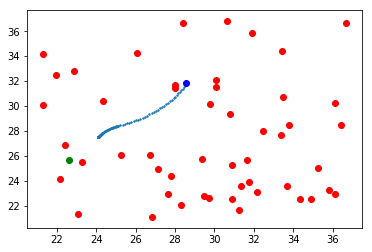

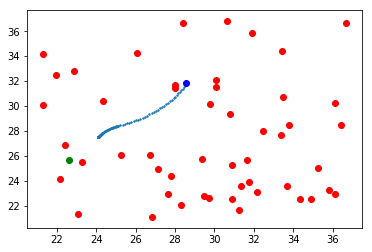

In [1259]:


pos_np=np.array(pos_list)
vel_np=np.array(vel_list)

pl.scatter(pos_np[:,0],pos_np[:,1],s=2)
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.show()

pos_np = np.array(r[0])
vel_np = np.array(r[1])


pl.scatter(pos_np[:,0],pos_np[:,1],s=2)
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')

## *Correctness by comparing both funcs*

In [52]:
for i in range(50):
    c = np.random.rand(2) * 10
    x = np.random.rand(3) * 10
    print(rollout(c,x), fast_rollout.rollout(
        c, x, end_point, obs_np)
         )

1014.7216270390182 1014.7216281284523
911.4074364865023 911.4074368540543
1334.5802782358228 1334.580278779126
1245.686086978662 1245.6860870351586
1308.8413394019547 1308.8413393461221
1052.6701371754702 1052.670136865159
1243.4839909785755 1243.4839915175517
1238.3047407628574 1238.3047404726062
1214.6532626849232 1214.6532634942982
892.9048313817593 892.9048321660341
1501.6479449775595 1501.6479506994967
1356.474389841753 1356.4743913075924
1466.393313398234 1466.393313334524
1407.2528779196575 1407.252877778707
1019.7883466098328 1019.7883470023374
1141.5035453846615 1141.5035457058636
1166.1400980706837 1166.1400987927639
883.6528108808628 883.6528120832448
1172.2100737830392 1172.2100749076496
1282.0808758102598 1282.0808743118796
1370.9707061976146 1370.9707062988243
853.6877695539199 853.6877701400863
971.015611649271 971.0156124126571
1446.4611921334727 1446.4611908976221
1263.5914261416794 1263.5914269208718
1020.6054926683653 1020.6054923209012
1433.6421247851492 1433.642122